[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cindyweng18/ccnychatbot/blob/main/chatbot.ipynb)

# CCNY Chatbot
### Team Members: Cindy Weng Zhu, David Jimenez, Sheriff Sanni, Nahim Imtiaz, Sajid Mahmud

Note: Please make sure to have Runtime Type as GPU

## Installs and Imports

In [ ]:
# Download questions cvs (questions to labels/intents)
!gdown "https://drive.google.com/uc?id=1uu6-ExY9OWkGmO9LuH1YP1Y1v7zOIx6t&export=download"

Downloading...
From: https://drive.google.com/uc?id=1uu6-ExY9OWkGmO9LuH1YP1Y1v7zOIx6t&export=download
To: /content/answers.json
100% 30.9k/30.9k [00:00<00:00, 13.5MB/s]


In [ ]:
# Download answers.json (matches intents to potential answers)
!gdown "https://drive.google.com/uc?id=1NLQ6yJlsdVctQqaV_AYsq71hEOdcw_RB&export=download"

Downloading...
From: https://drive.google.com/uc?id=1NLQ6yJlsdVctQqaV_AYsq71hEOdcw_RB&export=download
To: /content/test_chatbot.csv
100% 19.1k/19.1k [00:00<00:00, 8.20MB/s]


In [ ]:
# Install transformers
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 35.1 MB/s 
     |████████████████████████████████| 895 kB 40.9 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Install torchinfo to get model summary/info
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
import torchinfo
import json
import nltk
import spacy
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
device = torch.device("cuda")

## Preprocessing

In [ ]:
df = pd.read_csv("/content/test_chatbot.csv")

In [ ]:
df.head()

,Text,Label
0,What is City College looking for?,new_potential_student
1,How can I apply to City College?,new_potential_student
2,What GED score do I need?,ged_score
3,What is the GED score I need?,ged_score
4,Is there a GED score requirement?,ged_score


In [ ]:
df.describe()

,Text,Label
count,271,271
unique,270,121
top,How much is the application fee?,information_event
freq,2,17


In [ ]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
# check class distribution
df['Label'].value_counts(normalize = True)

64    0.062731
59    0.036900
40    0.029520
92    0.029520
2     0.025830
        ...   
66    0.003690
67    0.003690
68    0.003690
69    0.003690
0     0.003690
Name: Label, Length: 121, dtype: float64

In [ ]:
#converting Text column to lower case and remove punctuations
df['Text'] = df['Text'].str.lower().apply(lambda x: re.sub(r'[.,"\'-?:!;]', '', x))

In [ ]:
stop_words = stopwords.words('english')

df['text_without_stopwords'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
df['Text']

0                      what is city college looking for?
1                       how can i apply to city college?
2                              what ged score do i need?
3                          what is the ged score i need?
4                      is there a ged score requirement?
                             ...                        
266    what is the phone number of the front desk of ...
267      what is the office hours of the honors program?
268        what is the fax number of the honors program?
269           what is the address of the honors program?
270          who is the director of ccny honors program?
Name: Text, Length: 271, dtype: object

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()
nlp = spacy.load('en', disable=['parser', 'ner'])

In [ ]:
df.head(10)

,Text,Label,text_without_stopwords
0,what is city college looking for?,82,city college looking for?
1,how can i apply to city college?,82,apply city college?
2,what ged score do i need?,37,ged score need?
3,what is the ged score i need?,37,ged score need?
4,is there a ged score requirement?,37,ged score requirement?
5,what general educational development do i need?,37,general educational development need?
6,what is the general educational development i ...,37,general educational development need?
7,is there a general educational development req...,37,general educational development requirement?
8,when is the deadline?,1,deadline?
9,when do i have to apply?,1,apply?


In [ ]:
df['lem_text'] = df['text_without_stopwords'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))
df.tail(20)

,Text,Label,text_without_stopwords,lem_text
251,what is the email address of the international...,71,email address international students services?,email address international student service ?
252,what is the link of frequently asked questions...,72,link frequently asked questions internation st...,link frequently ask question internation stude...
253,where can i get update about internation stude...,76,get update internation students?,get update internation student ?
254,what is the link to student contact sheet?,68,link student contact sheet?,link student contact sheet ?
255,what is the link to form i-94?,75,link form i-94?,link form i-94 ?
256,how many credits are required to register full...,78,many credits required register full time inter...,many credit require register full time interna...
257,what are some immigration tips?,79,immigration tips?,immigration tip ?
258,what is the link for daca and dreamers?,69,link daca dreamers?,link daca dreamers ?
259,what is the phone number for international stu...,77,phone number international students service?,phone number international student service ?
260,what is the fax number for international stude...,73,fax number international student services?,fax number international student service ?


In [ ]:
train_text, train_labels = df['lem_text'], df['Label']

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


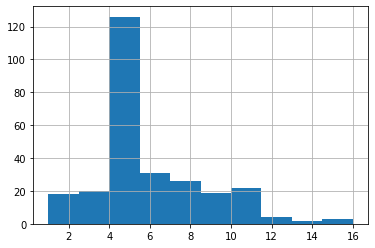

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)
max_seq_len = 10

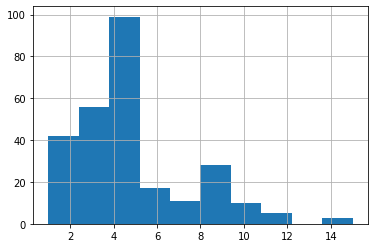

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['text_without_stopwords']]
pd.Series(seq_len).hist(bins = 10)
max_seq_len = 10

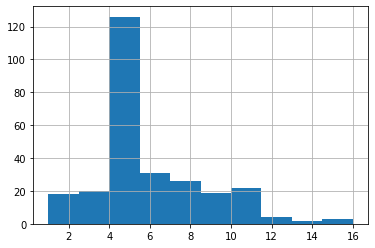

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['lem_text']]
pd.Series(seq_len).hist(bins = 10)
max_seq_len = 10

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
import nltk
from nltk import tokenize

tokenSpace = tokenize.WhitespaceTokenizer()
def counter(text, columnText, quantity):
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())}) 
    
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = dfFrequency, x = "Word", y = "Frequency", palette="deep")
    ax.set(ylabel = "Count")
    plt.xticks(rotation='horizontal')
    plt.show()

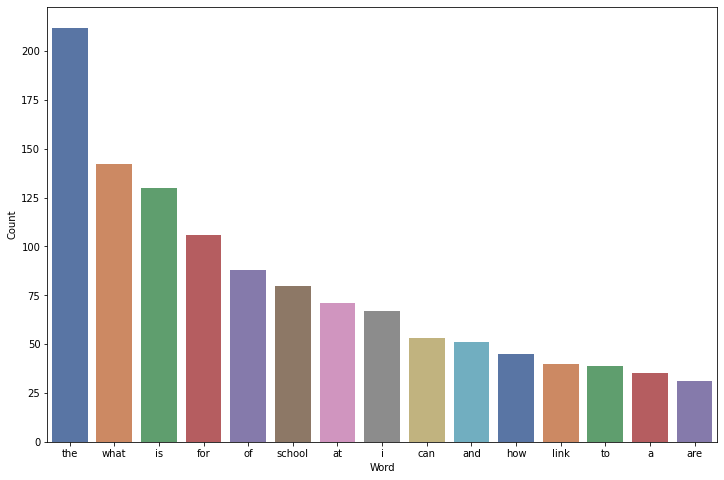

In [ ]:
counter(df, 'Text', 15)

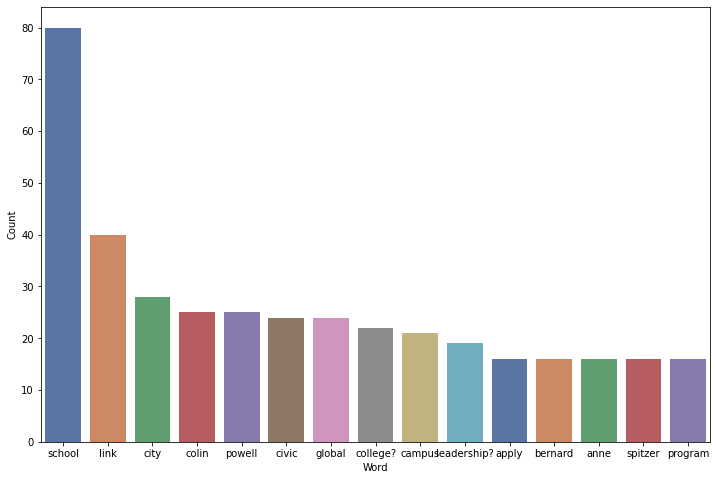

In [ ]:
counter(df, 'text_without_stopwords', 15)

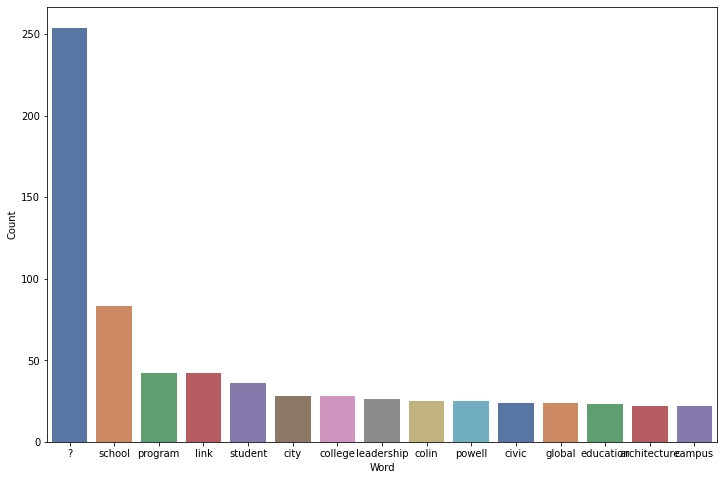

In [ ]:
counter(df, 'lem_text', 15)

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

## Model

In [ ]:
class BERT_Model(nn.Module):
    def __init__(self, bert):      
       super(BERT_Model, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,121)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [ ]:
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Model(bert)
# push the model to GPU
model = model.to(device)
# from torchinfo import summary
# summary(model)

In [ ]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print(class_wts)

[2.23966942 0.55991736 0.31995277 1.11983471 1.11983471 1.11983471
 1.11983471 0.44793388 0.74655647 1.11983471 1.11983471 1.11983471
 1.11983471 0.74655647 0.74655647 0.37327824 0.55991736 2.23966942
 2.23966942 2.23966942 2.23966942 2.23966942 0.55991736 0.74655647
 2.23966942 2.23966942 2.23966942 2.23966942 2.23966942 2.23966942
 2.23966942 2.23966942 2.23966942 1.11983471 2.23966942 2.23966942
 2.23966942 0.37327824 0.44793388 0.37327824 0.27995868 0.55991736
 0.37327824 2.23966942 2.23966942 2.23966942 2.23966942 2.23966942
 2.23966942 2.23966942 2.23966942 2.23966942 2.23966942 2.23966942
 2.23966942 2.23966942 2.23966942 2.23966942 2.23966942 0.22396694
 2.23966942 2.23966942 2.23966942 2.23966942 0.13174526 2.23966942
 2.23966942 2.23966942 2.23966942 2.23966942 2.23966942 2.23966942
 2.23966942 2.23966942 2.23966942 2.23966942 1.11983471 2.23966942
 2.23966942 2.23966942 2.23966942 0.44793388 1.11983471 0.55991736
 0.55991736 1.11983471 1.11983471 1.11983471 0.55991736 0.4479

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [ ]:
# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 200
# We can also use learning rate scheduler to achieve better results
# lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [ ]:
def train():
  
    model.train()
    total_loss = 0
  
  # empty list to save model predictions
    total_preds=[]
  
  # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>121,}  of  {:>121,}.'.format(step,    len(train_dataloader)))
        # push the batch to gpu
        batch = [r.to(device) for r in batch] 
        sent_id, mask, labels = batch
  
        # get model predictions for the current batch
        preds = model(sent_id, mask)
   
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # clear calculated gradients
        optimizer.zero_grad()

        # We are not using learning rate scheduler as of now
        # lr_sch.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
for epoch in range(epochs):
     
  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

  #train model
  train_loss, _ = train()

  # append training and validation loss
  train_losses.append(train_loss)
  # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 200

Training Loss: 4.876

 Epoch 2 / 200

Training Loss: 4.814

 Epoch 3 / 200

Training Loss: 4.789

 Epoch 4 / 200

Training Loss: 4.753

 Epoch 5 / 200

Training Loss: 4.684

 Epoch 6 / 200

Training Loss: 4.573

 Epoch 7 / 200

Training Loss: 4.448

 Epoch 8 / 200

Training Loss: 4.358

 Epoch 9 / 200

Training Loss: 4.239

 Epoch 10 / 200

Training Loss: 4.117

 Epoch 11 / 200

Training Loss: 4.022

 Epoch 12 / 200

Training Loss: 3.937

 Epoch 13 / 200

Training Loss: 3.822

 Epoch 14 / 200

Training Loss: 3.710

 Epoch 15 / 200

Training Loss: 3.633

 Epoch 16 / 200

Training Loss: 3.502

 Epoch 17 / 200

Training Loss: 3.433

 Epoch 18 / 200

Training Loss: 3.253

 Epoch 19 / 200

Training Loss: 3.228

 Epoch 20 / 200

Training Loss: 3.137

 Epoch 21 / 200

Training Loss: 3.176

 Epoch 22 / 200

Training Loss: 2.992

 Epoch 23 / 200

Training Loss: 2.920

 Epoch 24 / 200

Training Loss: 2.885

 Epoch 25 / 200

Training Loss: 2.846

 Epoch 26 / 200

Training Loss: 2

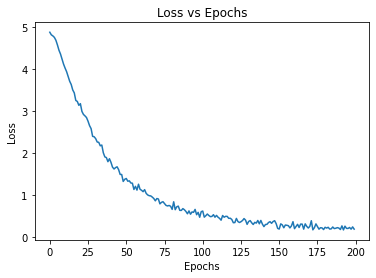

In [ ]:
plt.plot(train_losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Testing and Prediction

In [ ]:
data = json.load(open("/content/answers.json"))

In [ ]:
def get_prediction(str):
  str = re.sub(r'[^a-zA-Z ]+', '', str)
  test_text = [str]
  model.eval()

  tokens_test_data = tokenizer(
  test_text,
  max_length = max_seq_len,
  padding=True,
  truncation=True,
  return_token_type_ids=False
  )
  test_seq = torch.tensor(tokens_test_data['input_ids'])
  test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
  result = None
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
    result = preds[0]
    preds_index = np.argmax(preds, axis = 1)

  print("Intent Identified: ", le.inverse_transform(preds_index)[0])
  return le.inverse_transform(preds_index)[0]

In [ ]:
def get_response(message): 
  intent = get_prediction(message)
  result = ""
  for i in data['intents']: 
    if i["tag"] == intent:
      result = random.choice(i["responses"])
      break
  print(f"Response : {result}")
  return "Intent: "+ intent + '\n' + "Response: " + result

In [ ]:
# user_text = input("Type something: ")
# get_response(user_text)

In [ ]:
get_response("i want to apply to city college")

Intent Identified:  application_req
Response : Application:Submit official hs transcript, $65 non-refundable application fee. If you have a GED, submit your GED score. Applications, fees and all other documentation must be sent to the University Application Processing Center. Apply here: https://www.cuny.edu/admissions/undergraduate/. Please note Applications that are submitted after the deadline will be considered on a space available basis only.


'Intent: application_req\nResponse: Application:Submit official hs transcript, $65 non-refundable application fee. If you have a GED, submit your GED score. Applications, fees and all other documentation must be sent to the University Application Processing Center. Apply here: https://www.cuny.edu/admissions/undergraduate/. Please note Applications that are submitted after the deadline will be considered on a space available basis only.'

In [ ]:
get_prediction("How difficult is the workload at the school of medicine?")

Intent Identified:  grad_apply


'grad_apply'

In [ ]:
get_response("Who is the director of the honors program?")

Intent Identified:  honors_director
Response : Dr. Adrián Rodríguez-Contreras


'Intent: honors_director\nResponse: Dr. Adrián Rodríguez-Contreras'